<a href="https://colab.research.google.com/github/shamim-hussain/fashion-mnist-2layer-nn/blob/main/fashion_mnist_classification_2_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''From: https://github.com/zalandoresearch/fashion-mnist'''

!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2021-10-01 03:58:32--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.75.12
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.75.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz.3’

train-images-idx3-u 100%[===================>]  25.20M  10.6MB/s    in 2.4s    

2021-10-01 03:58:35 (10.6 MB/s) - ‘train-images-idx3-ubyte.gz.3’ saved [26421880/26421880]

--2021-10-01 03:58:35--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.75.12
Connecting to fashion-mnist.s3-website.eu-central-1.ama

In [2]:

'''From: https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py'''
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

X_train, Y_train = load_mnist('./', kind='train')
X_test, Y_test = load_mnist('./', kind='t10k')

In [3]:
print('Shape of data:', X_train.shape)
print('Type of data:', X_train.dtype)
print('Shape of data:', Y_train.shape)
print('Type of labes:', Y_train.dtype)

Shape of data: (60000, 784)
Type of data: uint8
Shape of data: (60000,)
Type of labes: uint8


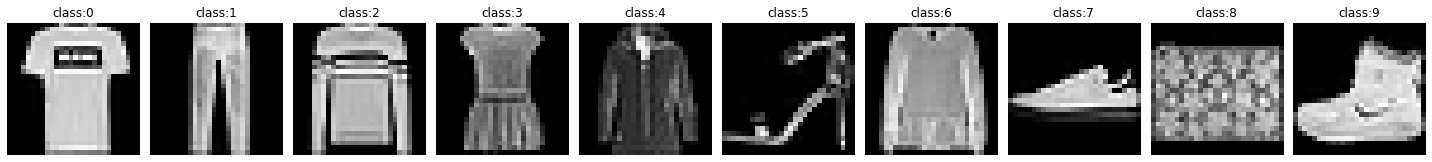

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Visualize data
plt.figure(figsize=[20,5])
for y in range(10):
    plt.subplot(1,10,1+y)
    plt.imshow(X_train[np.where(Y_train==y)[0][0]].reshape(28,28),cmap='gray')
    plt.axis('off')
    plt.title(f'class:{y}')
plt.tight_layout()
plt.show()

In [5]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Y_train = Y_train.astype('int64')
Y_test = Y_test.astype('int64')

(array([25790964.,  1344502.,  1582733.,  1643562.,  1876736.,  2034790.,
         2606932.,  3303752.,  4306392.,  2549637.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

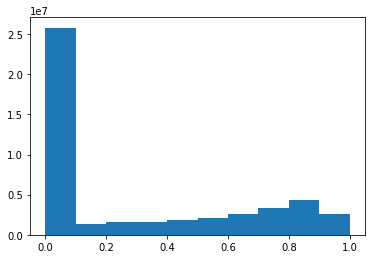

In [6]:
plt.hist(X_train.reshape(-1))

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print('Number of components', X_train_pca.shape[1])

Number of components 160


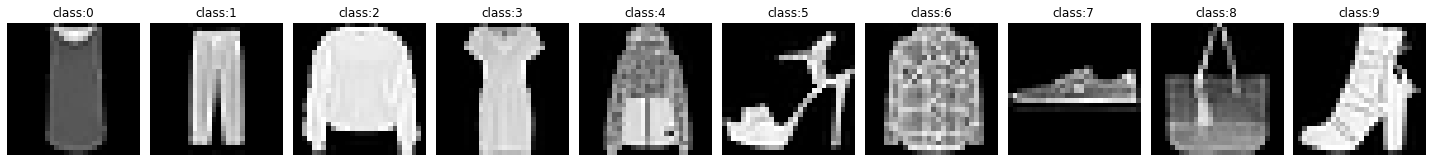

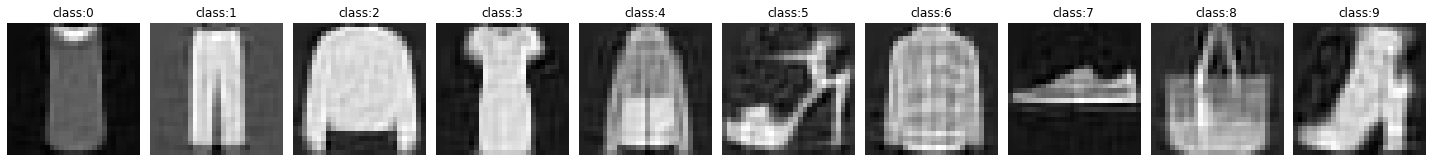

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# Visualize data
plt.figure(figsize=[20,5])
for y in range(10):
    plt.subplot(1,10,1+y)
    plt.imshow(X_train[np.where(Y_train==y)[0][1]].reshape(28,28),cmap='gray')
    plt.axis('off')
    plt.title(f'class:{y}')
plt.tight_layout()
plt.show()

plt.figure(figsize=[20,5])
for y in range(10):
    plt.subplot(1,10,1+y)
    plt.imshow(pca.inverse_transform(X_train_pca[np.where(Y_train==y)[0]])[1].reshape(28,28),cmap='gray')
    plt.axis('off')
    plt.title(f'class:{y}')
plt.tight_layout()
plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_pca)

X_train_pca = scaler.transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train_pca, Y_train, test_size=0.1, random_state=42)

X_test = X_test_pca

In [12]:
X_test.shape

(10000, 160)

In [13]:
import tensorflow as tf
from tensorflow.keras import models, optimizers, losses, metrics
from tensorflow.data import Dataset


num_feats = X_train.shape[1]


class NN2Layers(models.Model):
    def __init__(self, num_hidden=64, activation='relu', **kwargs):
        super().__init__(**kwargs)

        self.W1 = self.add_weight(shape=(num_feats,num_hidden), initializer='uniform')
        self.b1 = self.add_weight(shape=(num_hidden,), initializer='uniform')
        self.W2 = self.add_weight(shape=(num_hidden,10), initializer='uniform')
        self.b2 = self.add_weight(shape=(10,), initializer='uniform')

        if activation == 'sigmoid':
            self.activation_fn = tf.nn.sigmoid
        elif activation == 'relu':
            self.activation_fn = tf.nn.relu
        elif activation == 'tanh':
            self.activation_fn = tf.nn.tanh
    
    @tf.function
    def call(self, x):
        h1 = tf.matmul(x, self.W1) + self.b1
        a1 = self.activation_fn(h1)

        h2 = tf.matmul(a1, self.W2) + self.b2
        a2 = tf.nn.softmax(h2)
        return a2




In [15]:
from tqdm import trange

def train_model(X_t, Y_t, X_v, Y_v, model, optimizer='sgd', batch_size=32,
                  epochs=100, initial_lr=1e-2, decay=0.985, l2_loss=0.):
    train_dset = Dataset.from_tensor_slices((X_t, Y_t)).shuffle(len(X_t)).batch(batch_size)
    validation_dset = Dataset.from_tensor_slices((X_v, Y_v)).batch(batch_size)

    if optimizer == 'adam':
        optimizer = optimizers.Adam(initial_lr)
    if optimizer == 'rmsprop':
        optimizer = optimizers.RMSprop(initial_lr)
    if optimizer == 'sgd':
        optimizer = optimizers.SGD(initial_lr, momentum=0.5)
    
    loss_fn = losses.SparseCategoricalCrossentropy()
    loss_metric = metrics.SparseCategoricalCrossentropy()
    acc_metric = metrics.SparseCategoricalAccuracy()

    @tf.function
    def l2_loss_fn():
        return tf.reduce_sum(tf.square(model.W1)) + \
                tf.reduce_sum(tf.square(model.W2))
    @tf.function
    def training_loop():
        for X,Y in train_dset:
            with tf.GradientTape() as tape:
                Y_p = model(X)
                loss = loss_fn(Y,Y_p) + l2_loss*l2_loss_fn()

            
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads,model.trainable_variables))
            loss_metric.update_state(Y,Y_p)
            acc_metric.update_state(Y,Y_p)
    
    @tf.function
    def validation_loop():
        for X,Y in validation_dset:
            Y_p = model(X)
            loss_metric.update_state(Y,Y_p)
            acc_metric.update_state(Y,Y_p)

    gen = trange(epochs)
    try:
        for epoch in gen:
            # Training epoch
            loss_metric.reset_state()
            acc_metric.reset_state()
            training_loop()
            training_loss=loss_metric.result().numpy()
            training_acc=acc_metric.result().numpy()

            
            # Validation epoch
            loss_metric.reset_state()
            acc_metric.reset_state()
            validation_loop()
            validation_loss=loss_metric.result().numpy()
            validation_acc=acc_metric.result().numpy()

            optimizer.lr.assign(optimizer.lr*decay)

            gen.set_description(f'LR: {optimizer.lr.numpy():.3e} :: Training: loss={training_loss:0.4f}; acc={training_acc:.3%} :: Validation: loss={validation_loss:0.4f}; acc={validation_acc:.3%} ')
    finally:
        gen.close()

model=NN2Layers(num_hidden=128, activation='relu')
train_model(X_train, Y_train, X_val, Y_val, model, 'adam', 32, 200, 1e-3, 0.985, 1e-3)


LR: 4.867e-05 :: Training: loss=0.1641; acc=95.856% :: Validation: loss=0.3024; acc=89.200% : 100%|██████████| 200/200 [04:19<00:00,  1.30s/it]


In [ ]:
model.compile('adam', 'sparse_categorical_crossentropy', ['acc'])
model.fit(X_train, Y_train, batch_size=32, epochs=25, validation_data=(X_val, Y_val))